# 13. Creating a pipeline

In the previous chapter we created a procedure to isolate nuclei from images. Very often the goal is to repeat the exercise on multiple images in order to compare different conditions. Here we are going to see how to package our pipeline into a function, how to apply it to multiple images and how to plot the result for comparison. 

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
import skimage.io
import skimage.morphology
from scipy import ndimage as ndi

## 13.1 Creating an image processing function

We have seen previously how to define a function. It needs the ```def``` descriptor, a name and inputs. What we are doing here is just copying all the lines that we used for our pipeline in the last chapter into this function. At the moment the only input is the path to a given file to analyze. We also try to document what the function does, what its input/output are etc.

In [33]:
def my_pipeline(image_path):
    """
    This function extracts information about nuclei found in the third channel of an image
    loaded at the given path
    
    Parameters
    ----------
    image_path: str
        path to image
        
    Returns
    -------
    my_table: pandas dataframe
        dataframe with label, area, mean_intensity and extent information for each nucleus
    
    """
    
    image_stack = skimage.io.imread(image_path)
    
    image_nuclei = image_stack[:,:,2]#blue channel in RGB
    image_signal = image_stack[:,:,1]#green channel in RGB

    # filter image
    image_nuclei = skimage.filters.median(image_nuclei, skimage.morphology.disk(5))

    # create mask and clean-up
    mask_nuclei = image_nuclei > skimage.filters.threshold_otsu(image_nuclei)
    mask_nuclei = skimage.morphology.binary_closing(mask_nuclei, selem=skimage.morphology.disk(5))
    mask_nuclei = ndi.binary_fill_holes(mask_nuclei, skimage.morphology.disk(5))
    
    # label image
    my_labels = skimage.morphology.label(mask_nuclei)

    # measure
    my_regions = skimage.measure.regionprops_table(my_labels, image_signal, properties=('label','area', 'mean_intensity'))
    
    plt.subplots(figsize=(10,10))
    plt.imshow(mask_nuclei)
    plt.show()
    
    my_table = pd.DataFrame(my_regions)
    
    return my_table
                
                

We can now test our function with a single image:

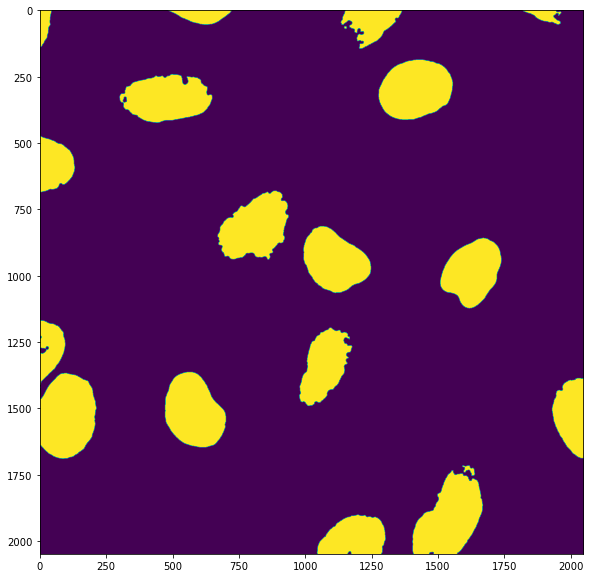

In [34]:
table = my_pipeline('https://github.com/guiwitz/PyImageCourse_beginner/raw/master/images/46658_784_B12_1.tif')

In [35]:
table

,label,area,mean_intensity
0,1,4221,79.265103
1,2,8386,65.997734
2,3,18258,70.261091
3,4,4043,63.026713
4,5,73,47.438356
5,6,49056,53.714510
6,7,45671,53.807099
7,8,20537,70.453912
8,9,46853,66.137729
9,10,43277,41.412552


## 13.2 Adjusting the function behavior

We have recovered the same result as previously and can analyze again our data as we did before. The mask is also plotted by default when calling the function. This is helpful to test the function and verify that nothing went dramatically wrong but we probably don't want to see this image if we analyze hundreds of images. What we can do is leave the user the choice to see it or not. Let's adjust our function to do that: we add an additional **optional** parameter ```do_plotting``` which is simply a boolean (```True```/```False```). If True, plotting is happening, if False it's not.

In [36]:
def my_pipeline(image_path, do_plotting=False):
    """
    This function extracts information about nuclei found in the third channel of an image
    loaded at the given path
    
    Parameters
    ----------
    image_path: str
        path to image
    do_plotting: bool
        show segmentation or not
        
    Returns
    -------
    my_table: pandas dataframe
        dataframe with label, area, mean_intensity and extent information for each nucleus
    
    """
    
    image_stack = skimage.io.imread(image_path)
    
    image_nuclei = image_stack[:,:,2]#blue channel in RGB
    image_signal = image_stack[:,:,1]#green channel in RGB

    # filter image
    image_nuclei = skimage.filters.median(image_nuclei, skimage.morphology.disk(5))

    # create mask and clean-up
    mask_nuclei = image_nuclei > skimage.filters.threshold_otsu(image_nuclei)
    mask_nuclei = skimage.morphology.binary_closing(mask_nuclei, selem=skimage.morphology.disk(5))
    mask_nuclei = ndi.binary_fill_holes(mask_nuclei, skimage.morphology.disk(5))
    
    # label image
    my_labels = skimage.morphology.label(mask_nuclei)

    # measure
    my_regions = skimage.measure.regionprops_table(my_labels, image_signal, properties=('label','area', 'mean_intensity'))
    
    if do_plotting:
        plt.subplots(figsize=(10,10))
        plt.imshow(mask_nuclei)
        plt.show()
    
    my_table = pd.DataFrame(my_regions)
    
    return my_table
                
                

In [37]:
table = my_pipeline('https://github.com/guiwitz/PyImageCourse_beginner/raw/master/images/46658_784_B12_1.tif')

Now indeed our function doesn't produce any output if we don't explicitly ask for it. 

## 13.3 Analyzing multiple images 

The point of creating an image processing pipeline was to be able to easily analyze multiple images. We can do that now by using a simple for loop. First we create a list of files we want to analyze and that we can see [here](http://flagella.crbs.ucsd.edu/images/13601) and [here](http://flagella.crbs.ucsd.edu/images/13585).

In [38]:
files_to_analyze = [
    'https://github.com/guiwitz/PyImageCourse_beginner/raw/master/images/46658_784_B12_1.tif',
    'https://github.com/guiwitz/PyImageCourse_beginner/raw/master/images/27897_273_C8_2.tif'
]

Now we create a for loop that will go through this list of files and analyze each of them with our function. As we did previously, before the loop, we create an empty list that is going to be filled with the output of the function. We also add to the output dataframe a column with the filename that we can recover by splitting the address ```files_to_analyze[0].split('/')[-1]```

In [40]:
all_tables = []
for file in files_to_analyze:
    
    #use the function
    new_table = my_pipeline(file)
    
    #add image index
    new_table['filename'] = file.split('/')[-1]
    
    #append the result to the list
    all_tables.append(new_table)
    

Finally we can concatenate our resutls into a single table:

In [42]:
complete_info = pd.concat(all_tables)
complete_info

,label,area,mean_intensity,filename
0,1,4221,79.265103,46658_784_B12_1.tif
1,2,8386,65.997734,46658_784_B12_1.tif
2,3,18258,70.261091,46658_784_B12_1.tif
3,4,4043,63.026713,46658_784_B12_1.tif
4,5,73,47.438356,46658_784_B12_1.tif
5,6,49056,53.714510,46658_784_B12_1.tif
6,7,45671,53.807099,46658_784_B12_1.tif
7,8,20537,70.453912,46658_784_B12_1.tif
8,9,46853,66.137729,46658_784_B12_1.tif
9,10,43277,41.412552,46658_784_B12_1.tif


We can then check if there's any difference in intensity in the nucleus between the two images:

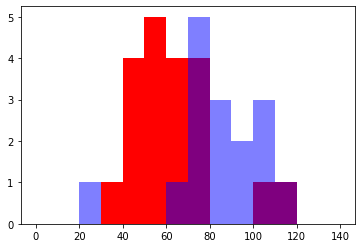

In [50]:
plt.hist(all_tables[0].mean_intensity, bins = np.arange(0,150,10), color = 'red')
plt.hist(all_tables[1].mean_intensity, bins = np.arange(0,150,10), alpha = 0.5, color = 'blue')
plt.show()

Of course our actual goal is not just to measure the intensity within the nucleus but to compare the intensity inside and on the edge of the nuclei. This is demonstrated in the [Demo](Demo.ipynb) notebooks.